<a href="https://colab.research.google.com/github/ananyakbcodes/CROP_PEST_DETECTION/blob/ANANYA/2_train_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# --- Step 1: Setup ---
!pip install kagglehub -q

import kagglehub
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/path/to/your/local/file.zip" "/content/drive/MyDrive/crop_project/data/"


Mounted at /content/drive
cp: cannot stat '/path/to/your/local/file.zip': No such file or directory


In [4]:
# --- Step 2: Download Dataset ---
path = kagglehub.dataset_download("emmarex/plantdisease")
print("✅ Dataset downloaded to:", path)


Using Colab cache for faster access to the 'plantdisease' dataset.
✅ Dataset downloaded to: /kaggle/input/plantdisease


In [ ]:
# --- Step 3: Split Dataset (Colab-safe version) ---
import os, shutil
from sklearn.model_selection import train_test_split

# Try KaggleHub or Kaggle API paths
source_dir = "/content/plant_disease_data/plantvillage/PlantVillage"

# If dataset not found, download automatically
if not os.path.exists(source_dir):
    print("🔽 Dataset not found locally. Downloading from Kaggle...")
    !pip install -q kaggle
    from google.colab import files
    files.upload()  # Upload your kaggle.json once
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d emmarex/plantdisease -p /content
    !unzip -q /content/plantdisease.zip -d /content/plant_disease_data
    source_dir = "/content/plant_disease_data/plantvillage/PlantVillage"

print("✅ Dataset ready at:", source_dir)

# Prepare directories
base_dir = "/content/plant_disease_data_split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Split images per class
for category in os.listdir(source_dir):
    category_path = os.path.join(source_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)
        for img in train_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))
        for img in val_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))

print("✅ Dataset split completed!")


🔽 Dataset not found locally. Downloading from Kaggle...


KeyboardInterrupt: 

In [5]:
# --- Step 3: Split Dataset ---
source_dir = "/kaggle/input/plantdisease/plantvillage/PlantVillage"

base_dir = "/content/plant_disease_data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for category in os.listdir(source_dir):
    category_path = os.path.join(source_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))
        for img in val_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))

print("✅ Dataset split completed!")


✅ Dataset split completed!


In [6]:
# --- Step 4: Data Generators ---
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 16504 images belonging to 15 classes.
Found 4134 images belonging to 15 classes.


In [7]:
# --- Step 5: Model ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,589,775 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# --- Step 6: Training ---
EPOCHS = 5  # increase later if you want better accuracy

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


516/516 ━━━━━━━━━━━━━━━━━━━━ 68s 98ms/step - accuracy: 0.6859 - loss: 0.9975 - val_accuracy: 0.8841 - val_loss: 0.3511
Epoch 2/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.8740 - loss: 0.3704 - val_accuracy: 0.8878 - val_loss: 0.3277
Epoch 3/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9084 - loss: 0.2749 - val_accuracy: 0.9040 - val_loss: 0.2906
Epoch 4/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9252 - loss: 0.2173 - val_accuracy: 0.9149 - val_loss: 0.2571
Epoch 5/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9374 - loss: 0.1838 - val_accuracy: 0.9088 - val_loss: 0.2810


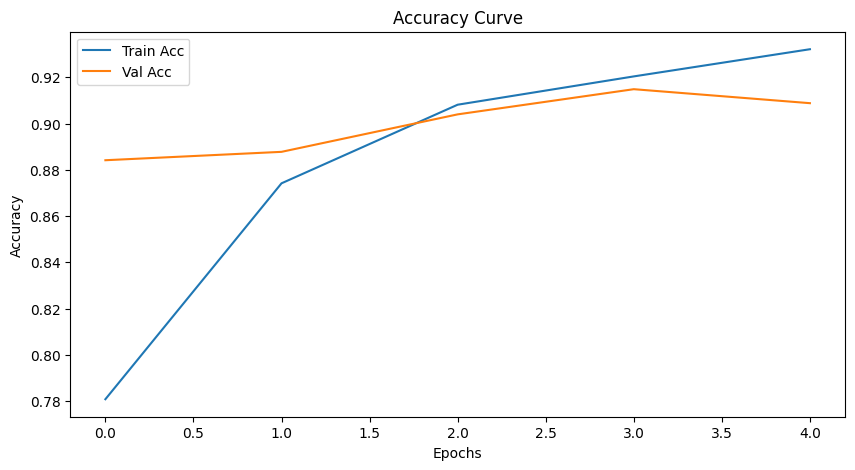

In [9]:
# --- Step 7: Visualization ---
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [10]:
# --- Step 8: Save Model ---
os.makedirs("/content/models", exist_ok=True)
model.save("/content/models/cnn_model.h5")
print("✅ Model saved successfully at /content/models/cnn_model.h5")


✅ Model saved successfully at /content/models/cnn_model.h5


In [11]:

import os
os.makedirs("/content/models", exist_ok=True)
model.save("/content/models/cnn_model.h5")
print("✅ Model saved successfully at /content/models/cnn_model.h5")



✅ Model saved successfully at /content/models/cnn_model.h5


In [13]:
from google.colab import files
files.download('/content/models/cnn_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>